In [1]:
from pathlib import Path
from imitative_agent import ImitativeAgent
import pickle
import yaml
import matplotlib.pyplot as plt
from tqdm import tqdm
from lib.dataset_wrapper import Dataset
import numpy as np
from pathlib import Path
from lib import utils
from lib import abx_utils

ABX_NB_SAMPLES = 100

distance = {
        "art_estimated": {
            "metric": "cosine",
            "weight": 1,
        },
    }

# See two last cells for how to compute this
abx_gold_cepstrum = {'manner': 91.525, 'place': 70.52083333333333, 'global': 89.41520467836257}
abx_gold_art_params = {'manner': 63.46666666666666, 'place': 86.22916666666667, 'global': 80.21929824561404}

In [4]:
model_path = Path('../out/imitative_agent/babbling_exp')
basenames = ['imitative_random_babbling_0', 'imitative_random_babbling_1', 
             'imitative_random_babbling_2', 'imitative_random_babbling_3', 
             'imitative_random_babbling_4', 'imitative_babbling_no_aug',
             'imitative', 'imitative_babbling', 
             'imitative_babbling_no_aug_random_0', 'imitative_babbling_no_aug_random_1',
             'imitative_babbling_no_aug_random_2']

agents_abx_matrices = utils.pickle_load(model_path / 'abx_cache.pickle', {})
for basename in tqdm(basenames):
    for seed in tqdm(range(5), leave=False):
        agent_path = model_path / (basename + f'_seed_{seed}')
        if agent_path not in agents_abx_matrices:
            agents_abx_matrices[agent_path] = {}
        agent_abx_matrices = agents_abx_matrices[agent_path]

        agent = ImitativeAgent.reload(str(agent_path))
        # Load vowels and consonants info
        main_dataset = agent.get_main_dataset()
        consonants = main_dataset.phones_infos["consonants"]
        in_consonants = ['b', 'm', 'd', 'n', 'g']
        out_consonants = list(set(consonants) - set(in_consonants))
        vowels = main_dataset.phones_infos["vowels"]
        in_vowels = ['a', 'e^', 'e', 'x', 'x^', 'e~', 'y', 'u', 'o~', 'a~']
        out_vowels = list(set(vowels) - set(in_vowels))

        consonant_babbling_groups = {
            'in_consonant_babbling': [in_consonants],
            'out_consonant_babbling': [out_consonants]
        }


        # Compute ABX on VCV triplets
        distance_signature = abx_utils.get_distance_signature(distance)
        if distance_signature in agent_abx_matrices: continue
        agent_lab = agent.get_datasplit_lab(2)
        agent_features = agent.repeat_datasplit(2)

        # Compute ABX with all vocalic contexts
        consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, agent_features, distance, ABX_NB_SAMPLES, seed=43)
        agent_abx_matrices[distance_signature] = abx_matrix
        utils.pickle_dump(model_path / 'abx_cache.pickle', agents_abx_matrices)

abx_results = {basename:{'manner': [], 'place': [], 'global': []} for basename in basenames}
for basename in basenames:
    for seed in range(5):
        agent_path = model_path / (basename + f'_seed_{seed}')
        distance_signature = abx_utils.get_distance_signature(distance)
        agent_abx_matrix = agents_abx_matrices[agent_path][distance_signature]
        score = abx_utils.get_groups_score(consonants, agent_abx_matrix, main_dataset.phones_infos["consonant_groups"])
        score['global'] = abx_utils.get_global_score(agent_abx_matrix)
        for kind in ['manner', 'place', 'global']:
            abx_results[basename][kind].append(score[kind])
            
abx_results['imitative_random_babbling'] = {'manner': [], 'place': [], 'global': []} 
abx_results['imitative_random_babbling_no_aug'] = {'manner': [], 'place': [], 'global': []} 

for kind in ['global', 'manner', 'place']:
    abx_results['imitative_random_babbling'][kind] = np.concatenate([abx_results['imitative_random_babbling_0'][kind],
                                                                     abx_results['imitative_random_babbling_1'][kind],
                                                                     abx_results['imitative_random_babbling_2'][kind],
                                                                     abx_results['imitative_random_babbling_3'][kind],
                                                                     abx_results['imitative_random_babbling_4'][kind]])
    abx_results['imitative_random_babbling_no_aug'][kind] = np.concatenate([abx_results['imitative_babbling_no_aug_random_0'][kind],
                                                                     abx_results['imitative_babbling_no_aug_random_1'][kind],
                                                                     abx_results['imitative_babbling_no_aug_random_2'][kind]])

100%|███████████████████████████████████████████| 11/11 [00:36<00:00,  3.30s/it]


In [108]:
abx_results

{'imitative_random_babbling_0': {'manner': [80.01666666666667,
   81.86666666666666,
   80.65,
   79.93333333333332,
   84.78333333333333],
  'place': [70.375,
   71.83333333333334,
   77.04166666666667,
   72.91666666666667,
   69.58333333333333],
  'global': [83.59356725146199,
   84.62573099415205,
   83.63450292397661,
   84.55555555555556,
   85.3391812865497]},
 'imitative_random_babbling_1': {'manner': [80.35,
   78.31666666666666,
   79.53333333333333,
   79.93333333333332,
   80.58333333333333],
  'place': [72.04166666666667,
   69.24999999999999,
   76.49999999999999,
   72.0,
   66.54166666666667],
  'global': [83.26900584795321,
   81.79239766081872,
   82.99122807017544,
   83.78654970760235,
   82.71345029239767]},
 'imitative_random_babbling_2': {'manner': [83.55,
   79.78333333333333,
   80.88333333333333,
   81.33333333333333,
   84.26666666666667],
  'place': [75.83333333333333,
   67.08333333333333,
   76.41666666666667,
   68.66666666666666,
   69.04166666666667],
 

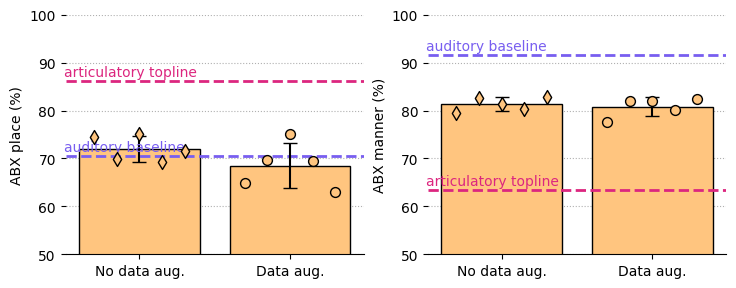

In [10]:
##### Comparing babbling with augmented babbling
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 10, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':5, 'lines.linewidth':1})

markers = ['d', 'o']
color = {
    'acoustic': '#785EF0',
    'articulatory': '#DC267F',
    'learned' : '#ffc57f'
}

cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18.4*cm,7.04*cm), constrained_layout=True)

# to be replaced with imitative babbling
conditions = ['imitative_babbling_no_aug', 'imitative_babbling']
kind = 'place'
X = list(range(len(conditions)))
Y = [np.mean(abx_results[cond][kind]) for cond in conditions]
Yerr = [np.std(abx_results[cond][kind], ddof=1) for cond in conditions]

ax1.bar(X, Y, yerr=Yerr, color=color['learned'], error_kw=dict(lw=1.5, capsize=5), edgecolor='black', zorder=2)
ax1.axhline(abx_gold_cepstrum[kind], linestyle='--', color=color['acoustic'], linewidth=2)
ax1.axhline(abx_gold_art_params[kind], linestyle='--', color=color['articulatory'], linewidth=2)
ax1.text(x=-0.5, y=abx_gold_cepstrum[kind]+1, s='auditory baseline', horizontalalignment='left', fontsize=10, color=color['acoustic'])
ax1.text(x=-0.5, y=abx_gold_art_params[kind]+1, s='articulatory topline', horizontalalignment='left', fontsize=10, color=color['articulatory'])
ax1.set_ylabel("ABX place (%)")
ax1.set_xticks(X)
ax1.set_xticklabels(['No data aug.',  'Data aug.'])
for i in range(len(conditions)):
    cond = conditions[i]
    Y = abx_results[cond][kind]
    X = i + np.linspace(-.3, .3, 5)
    ax1.scatter(X, Y, color=color['learned'], zorder=3, s=50, edgecolors='black', marker=markers[i])

# to be replaced with imitative babbling
conditions = ['imitative_babbling_no_aug', 'imitative_babbling']
kind = 'manner'
X = list(range(len(conditions)))
Y = [np.mean(abx_results[cond][kind]) for cond in conditions]
Yerr = [np.std(abx_results[cond][kind], ddof=1) for cond in conditions]

ax2.bar(X, Y, yerr=Yerr, color=color['learned'], error_kw=dict(lw=1.5, capsize=5), edgecolor='black', zorder=2)

ax2.axhline(abx_gold_cepstrum[kind], linestyle='--',  color=color['acoustic'], linewidth=2)
ax2.axhline(abx_gold_art_params[kind], linestyle='--', color=color['articulatory'], linewidth=2)
ax2.text(x=-0.5, y=abx_gold_cepstrum[kind]+1, s='auditory baseline', horizontalalignment='left', fontsize=10, color=color['acoustic'])
ax2.text(x=-0.5, y=abx_gold_art_params[kind]+1, s='articulatory topline', horizontalalignment='left', fontsize=10, color=color['articulatory'])
ax2.set_ylabel("ABX manner (%)")
ax2.set_xticks(X)
ax2.set_xticklabels(['No data aug.',  'Data aug.'])
for i in range(len(conditions)):
    cond = conditions[i]
    Y = abx_results[cond][kind]
    X = i + np.linspace(-.3, .3, 5)
    ax2.scatter(X, Y, color=color['learned'], zorder=3, s=50, edgecolors='black', marker=markers[i])

for ax in [ax1, ax2]:
    ax.grid(visible=True, axis='y', linestyle=':',zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_ylim(50, 100)
    
plt.savefig('/home/engaclew/agent/out/imitative_agent/babbling_exp/no_aug_vs_aug.png', dpi=300)

In [8]:
print(abx_results['imitative_babbling_no_aug']['place'])
print(abx_results['imitative_babbling']['place'])

[74.45833333333334, 69.79166666666666, 75.04166666666667, 69.20833333333334, 71.54166666666666]
[64.875, 69.75, 75.08333333333334, 69.5, 63.083333333333336]


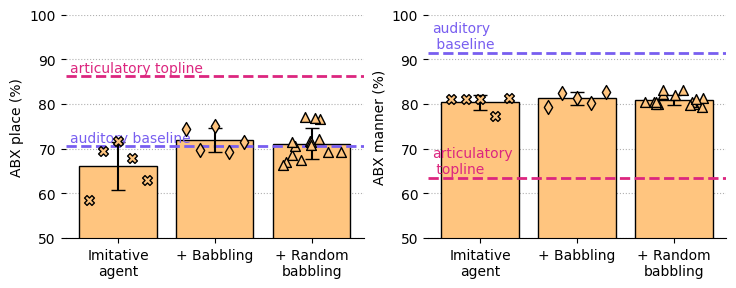

In [15]:
# Comparing classic vs babbling vs random babbling

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 10, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':5, 'lines.linewidth':1})

color = {
    'acoustic': '#785EF0',
    'articulatory': '#DC267F',
    'learned' : '#ffc57f'
}

markers = ['X', 'd', '^']
cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18.4*cm,7.04*cm), constrained_layout=True)

conditions = ['imitative', 'imitative_babbling_no_aug', 'imitative_random_babbling_no_aug']
kind = 'place'
X = list(range(len(conditions)))
Y = [np.mean(abx_results[cond][kind]) for cond in conditions]
Yerr = [np.std(abx_results[cond][kind], ddof=1) for cond in conditions]

ax1.bar(X, Y, yerr=Yerr, color=color['learned'], error_kw=dict(lw=1.5, capsize=5), edgecolor='black', zorder=2)
ax1.axhline(abx_gold_cepstrum[kind], linestyle='--', color=color['acoustic'], linewidth=2)
ax1.axhline(abx_gold_art_params[kind], linestyle='--', color=color['articulatory'], linewidth=2)
ax1.text(x=-0.5, y=abx_gold_cepstrum[kind]+1, s='auditory baseline', horizontalalignment='left', fontsize=10, color=color['acoustic'])
ax1.text(x=-0.5, y=abx_gold_art_params[kind]+1, s='articulatory topline', horizontalalignment='left', fontsize=10, color=color['articulatory'])
ax1.set_ylabel("ABX place (%)")
ax1.set_xticks(X)
ax1.set_xticklabels(['Imitative\nagent', '+ Babbling', '+ Random\nbabbling'])
for i in range(len(conditions)):
    cond = conditions[i]
    Y = abx_results[cond][kind]
    if cond == 'imitative_random_babbling' or cond == 'imitative_random_babbling_no_aug':
        noise = np.random.normal(0, 1, 15)
        noise = .6*(noise - noise.min()) / (noise.max() - noise.min()) - .3
        X = i + noise
    else:
        X = i + np.linspace(-.3, .3, 5)
    ax1.scatter(X, Y, color=color['learned'], zorder=3, s=50, edgecolors='black', marker=markers[i])

conditions = ['imitative', 'imitative_babbling_no_aug', 'imitative_random_babbling_no_aug']
kind = 'manner'
X = list(range(len(conditions)))
Y = [np.mean(abx_results[cond][kind]) for cond in conditions]
Yerr = [np.std(abx_results[cond][kind], ddof=1) for cond in conditions]

ax2.bar(X, Y, yerr=Yerr, color=color['learned'], error_kw=dict(lw=1.5, capsize=5), edgecolor='black', zorder=2)

ax2.axhline(abx_gold_cepstrum[kind], linestyle='--',  color=color['acoustic'], linewidth=2)
ax2.axhline(abx_gold_art_params[kind], linestyle='--', color=color['articulatory'], linewidth=2)
ax2.text(x=-0.5, y=abx_gold_cepstrum[kind]+1, s='auditory\n baseline', horizontalalignment='left', fontsize=10, color=color['acoustic'])
ax2.text(x=-0.5, y=abx_gold_art_params[kind]+1, s='articulatory\n topline', horizontalalignment='left', fontsize=10, color=color['articulatory'])
ax2.set_ylabel("ABX manner (%)")
ax2.set_xticks(X)
ax2.set_xticklabels(['Imitative\nagent', '+ Babbling', '+ Random\nbabbling'])
for i in range(len(conditions)):
    cond = conditions[i]
    Y = abx_results[cond][kind]
    if cond == 'imitative_random_babbling' or cond == 'imitative_random_babbling_no_aug':
        noise = np.random.normal(0, 1, 15)
        noise = .6*(noise - noise.min()) / (noise.max() - noise.min()) - .3
        X = i + noise
    else:
        X = i + np.linspace(-.3, .3, 5)
    ax2.scatter(X, Y, color=color['learned'], zorder=3, s=50, edgecolors='black', marker=markers[i])

for ax in [ax1, ax2]:
    ax.grid(visible=True, axis='y', linestyle=':',zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_ylim(50, 100)
plt.savefig('/home/engaclew/agent/out/imitative_agent/babbling_exp/effect_babbling.png', dpi=300)

In [16]:
model_path = Path('../out/imitative_agent/babbling_exp')
basenames = ['imitative', 'imitative_babbling_no_aug']
    
# 2. Babbled vocalic context
agents_abx_matrices_2 = utils.pickle_load(model_path / 'abx_cache_babbled_vowels.pickle', {})
for basename in tqdm(basenames):
    for seed in tqdm(range(5), leave=False):
        agent_path = model_path / (basename + f'_seed_{seed}')
        if agent_path not in agents_abx_matrices_2:
            agents_abx_matrices_2[agent_path] = {}
        agent_abx_matrices_2 = agents_abx_matrices_2[agent_path]

        agent = ImitativeAgent.reload(str(agent_path))
        # Load vowels and consonants info
        main_dataset = agent.get_main_dataset()
        consonants = main_dataset.phones_infos["consonants"]
        in_consonants = ['b', 'm', 'd', 'n', 'g']
        out_consonants = list(set(consonants) - set(in_consonants))
        vowels = main_dataset.phones_infos["vowels"]
        in_vowels = ['a', 'e^', 'e', 'x', 'x^', 'e~', 'y', 'u', 'o~', 'a~']
        out_vowels = list(set(vowels) - set(in_vowels))

        consonant_babbling_groups = {
            'in_consonant_babbling': [in_consonants],
            'out_consonant_babbling': [out_consonants]
        }


        # Compute ABX on VCV triplets
        distance_signature = abx_utils.get_distance_signature(distance)
        if distance_signature in agent_abx_matrices_2: continue
        agent_lab = agent.get_datasplit_lab(2)
        agent_features = agent.repeat_datasplit(2)

        # Compute ABX with babbled vocalic contexts
        consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, in_vowels)
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, agent_features, distance, ABX_NB_SAMPLES, seed=43)
        agent_abx_matrices_2[distance_signature] = abx_matrix
        utils.pickle_dump(model_path / 'abx_cache_babbled_vowels.pickle', agents_abx_matrices_2)

# 3. Unbabbled vocalic context
agents_abx_matrices_3 = utils.pickle_load(model_path / 'abx_cache_unbabbled_vowels.pickle', {})
for basename in tqdm(basenames):
    for seed in range(5):
        agent_path = model_path / (basename + f'_seed_{seed}')
        if agent_path not in agents_abx_matrices_3:
            agents_abx_matrices_3[agent_path] = {}
        agent_abx_matrices_3 = agents_abx_matrices_3[agent_path]

        agent = ImitativeAgent.reload(str(agent_path))
        # Load vowels and consonants info
        main_dataset = agent.get_main_dataset()
        consonants = main_dataset.phones_infos["consonants"]
        in_consonants = ['b', 'm', 'd', 'n', 'g']
        out_consonants = list(set(consonants) - set(in_consonants))
        vowels = main_dataset.phones_infos["vowels"]
        in_vowels = ['a', 'e^', 'e', 'x', 'x^', 'e~', 'y', 'u', 'o~', 'a~']
        out_vowels = list(set(vowels) - set(in_vowels))

        consonant_babbling_groups = {
            'in_consonant_babbling': [in_consonants],
            'out_consonant_babbling': [out_consonants]
        }


        # Compute ABX on VCV triplets
        distance_signature = abx_utils.get_distance_signature(distance)
        if distance_signature in agent_abx_matrices_3: continue
        agent_lab = agent.get_datasplit_lab(2)
        agent_features = agent.repeat_datasplit(2)

        # Compute ABX with babbled vocalic contexts
        consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, out_vowels)
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, agent_features, distance, ABX_NB_SAMPLES, seed=43)
        agent_abx_matrices_3[distance_signature] = abx_matrix
        utils.pickle_dump(model_path / 'abx_cache_unbabbled_vowels.pickle', agents_abx_matrices_3)

abx_results = {basename : {'babbled_vocalic_contexts': {'in_consonant_babbling': [], 'out_consonant_babbling': []},
                           'unbabbled_vocalic_contexts': {'in_consonant_babbling': [], 'out_consonant_babbling': []}} 
               for basename in basenames}
for basename in basenames:
    for seed in range(5):
        agent_path = model_path / (basename + f'_seed_{seed}')
        distance_signature = abx_utils.get_distance_signature(distance)
        # Babbled vocalic contexts
        agent_abx_matrix_2 = agents_abx_matrices_2[agent_path][distance_signature]
        score = abx_utils.get_groups_score(consonants, agent_abx_matrix_2, consonant_babbling_groups)
        score['global'] = abx_utils.get_global_score(agent_abx_matrix_2)
        
        for kind in ['in_consonant_babbling', 'out_consonant_babbling']:
            abx_results[basename]['babbled_vocalic_contexts'][kind].append(score[kind])
        
        # Unbabbled vocalic contexts
        agent_abx_matrix_3 = agents_abx_matrices_3[agent_path][distance_signature]
        score = abx_utils.get_groups_score(consonants, agent_abx_matrix_3, consonant_babbling_groups)
        score['global'] = abx_utils.get_global_score(agent_abx_matrix_3)
        for kind in ['in_consonant_babbling', 'out_consonant_babbling']:
            abx_results[basename]['unbabbled_vocalic_contexts'][kind].append(score[kind])

100%|█████████████████████████████████████████████| 2/2 [01:04<00:00, 32.44s/it]


In [61]:
abx_results

{'imitative': {'babbled_vocalic_contexts': {'in_consonant_babbling': [62.4,
    67.55,
    64.4,
    76.3,
    70.0],
   'out_consonant_babbling': [83.11834319526628,
    81.70879120879121,
    85.08241758241758,
    84.87912087912089,
    77.17582417582418]},
  'unbabbled_vocalic_contexts': {'in_consonant_babbling': [54.5625,
    89.66666666666666,
    71.25,
    48.0625,
    56.6875],
   'out_consonant_babbling': [76.61538461538461,
    73.02222222222223,
    82.14393939393939,
    84.39053254437869,
    83.09027777777777]}},
 'imitative_babbling': {'babbled_vocalic_contexts': {'in_consonant_babbling': [77.5,
    64.60000000000001,
    72.35000000000001,
    73.9,
    71.95],
   'out_consonant_babbling': [77.33727810650888,
    84.92857142857143,
    85.73076923076923,
    86.32967032967032,
    78.09340659340658]},
  'unbabbled_vocalic_contexts': {'in_consonant_babbling': [79.4375,
    80.33333333333333,
    75.5,
    42.875,
    55.25],
   'out_consonant_babbling': [75.055944055944

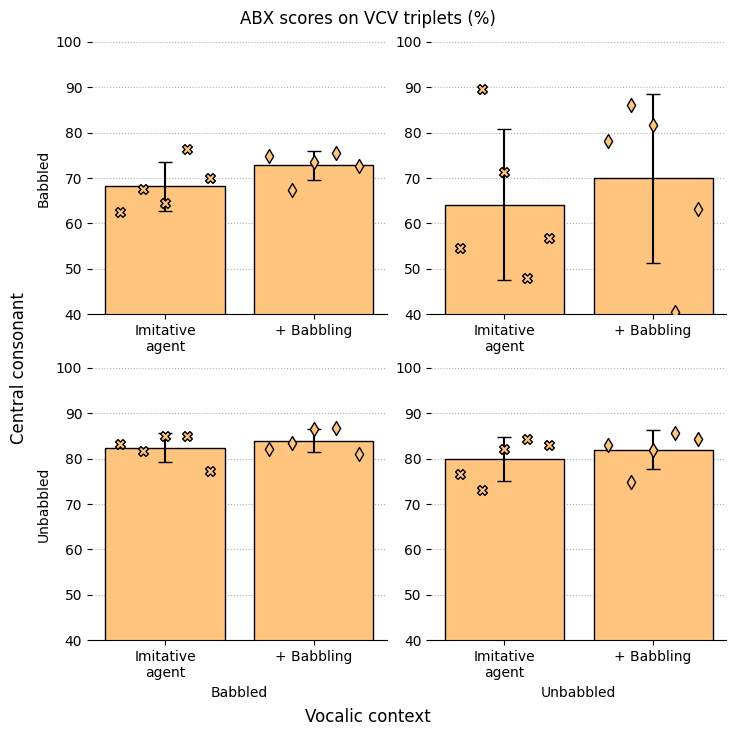

In [19]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 10, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':5, 'lines.linewidth':1})

color = {
    'acoustic': '#785EF0',
    'articulatory': '#DC267F',
    'learned' : '#ffc57f'
}

cm = 1/2.54
fig, ax = plt.subplots(2, 2, figsize=(18.4*cm,18.4*cm), constrained_layout=True)

voc_context = 'babbled_vocalic_contexts'
kind = 'in_consonant_babbling'
conditions = ['imitative', 'imitative_babbling_no_aug']

X = list(range(len(conditions)))
Y = [np.mean(abx_results[cond][voc_context][kind]) for cond in conditions]
Yerr = [np.std(abx_results[cond][voc_context][kind], ddof=1) for cond in conditions]
ax[0,0].bar(X, Y, yerr=Yerr, color=color['learned'], error_kw=dict(lw=1.5, capsize=5), edgecolor='black', zorder=2)
    
voc_context = 'babbled_vocalic_contexts'
kind = 'out_consonant_babbling'
conditions = ['imitative', 'imitative_babbling_no_aug']
X = list(range(len(conditions)))
Y = [np.mean(abx_results[cond][voc_context][kind]) for cond in conditions]
Yerr = [np.std(abx_results[cond][voc_context][kind], ddof=1) for cond in conditions]
ax[1,0].bar(X, Y, yerr=Yerr, color=color['learned'], error_kw=dict(lw=1.5, capsize=5), edgecolor='black', zorder=2)
    
voc_context = 'unbabbled_vocalic_contexts'
kind = 'in_consonant_babbling'
conditions = ['imitative', 'imitative_babbling_no_aug']
X = list(range(len(conditions)))
Y = [np.mean(abx_results[cond][voc_context][kind]) for cond in conditions]
Yerr = [np.std(abx_results[cond][voc_context][kind], ddof=1) for cond in conditions]
ax[0,1].bar(X, Y, yerr=Yerr, color=color['learned'], error_kw=dict(lw=1.5, capsize=5), edgecolor='black', zorder=2)
    
voc_context = 'unbabbled_vocalic_contexts'
kind = 'out_consonant_babbling'
conditions = ['imitative', 'imitative_babbling_no_aug']
X = list(range(len(conditions)))
Y = [np.mean(abx_results[cond][voc_context][kind]) for cond in conditions]
Yerr = [np.std(abx_results[cond][voc_context][kind], ddof=1) for cond in conditions]
ax[1,1].bar(X, Y, yerr=Yerr, color=color['learned'], error_kw=dict(lw=1.5, capsize=5), edgecolor='black', zorder=2)

fig.supylabel('Central consonant')
ax[0,0].set_ylabel('Babbled')
ax[1,0].set_ylabel('Unbabbled')

fig.supxlabel('Vocalic context')
ax[1,0].set_xlabel('Babbled')
ax[1,1].set_xlabel('Unbabbled')

fig.suptitle('ABX scores on VCV triplets (%)')

for i in range(2):
    for j in range(2):
        ax[i,j].set_ylim(40, 100)
        ax[i,j].grid(visible=True, axis='y', linestyle=':',zorder=0)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['left'].set_visible(False)
        ax[i,j].set_xticks(X)
        ax[i,j].set_xticklabels(['Imitative\nagent', '+ Babbling'])
        
voc_contexts = ['babbled_vocalic_contexts', 'unbabbled_vocalic_contexts']
kinds = ['in_consonant_babbling', 'out_consonant_babbling']
for i in range(2):
    for j in range(2):
        for k in range(2):
            voc_context = voc_contexts[j]
            kind = kinds[i]
            cond = conditions[k]
            Y = abx_results[cond][voc_context][kind]
            X = k + np.linspace(-.3, .3, 5)
            ax[i,j].scatter(X, Y, color=color['learned'], zorder=3, s=50, edgecolors='black', marker=markers[k])
  
plt.savefig('/home/engaclew/agent/out/imitative_agent/babbling_exp/babbled_vs_unbabbled.png', dpi=300)
plt.show()

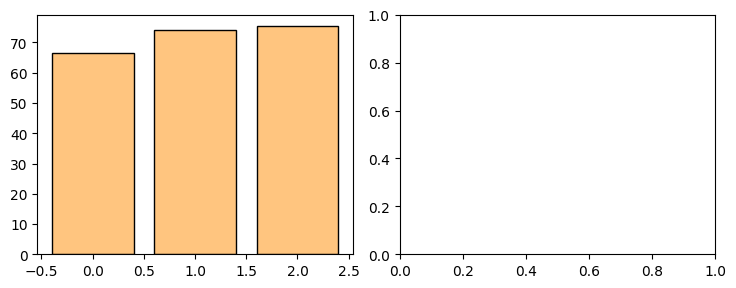

In [9]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 10, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':5, 'lines.linewidth':1})

color = {
    'acoustic': '#785EF0',
    'articulatory': '#DC267F',
    'learned' : '#ffc57f'
}

cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18.4*cm,7.04*cm), constrained_layout=True)

# babbled
voc_context = 'babbled_vocalic_contexts'
conditions = ['classic', 'classic_with_babblings_no_aug', 'classic_with_babblings']
kind = 'place'
X = list(range(len(conditions)))
Y = [abx_results[voc_context][cond][kind] for cond in conditions]
ax1.bar(X, Y, color=color['learned'], edgecolor='black', zorder=2)

plt.show()


In [10]:
abx_results

{'all_vocalic_contexts': {'classic': {'manner': 80.21666666666668,
   'place': 65.83333333333333,
   'global': 82.28070175438596},
  'classic_with_babblings_no_aug': {'manner': 81.61666666666667,
   'place': 73.47916666666667,
   'global': 84.79970760233918},
  'classic_with_babblings': {'manner': 82.30833333333332,
   'place': 75.68750000000001,
   'global': 85.1374269005848}},
 'babbled_vocalic_contexts': {'classic': {'manner': 81.33333333333333,
   'place': 66.58333333333334,
   'global': 81.41975308641976},
  'classic_with_babblings_no_aug': {'manner': 82.0,
   'place': 74.0,
   'global': 83.80864197530865},
  'classic_with_babblings': {'manner': 81.4,
   'place': 75.41666666666667,
   'global': 83.04320987654322}},
 'unbabbled_vocalic_contexts': {'classic': {'manner': 84.78055555555555,
   'place': 71.91666666666667,
   'global': 81.88888888888889},
  'classic_with_babblings_no_aug': {'manner': 86.275,
   'place': 72.0,
   'global': 81.96296296296296},
  'classic_with_babblings': 

In [13]:
# Compute gold ABX on cepstrum
distance = {
        "cepstrum_real": {
            "metric": "cosine",
            "weight": 1,
        },
    }
agent_path = model_path / basenames[0]
agent = ImitativeAgent.reload(str(agent_path))
main_dataset = agent.get_main_dataset()
agent_lab = agent.get_datasplit_lab(2)
real_cepstrum = main_dataset.get_items_modality_data('cepstrum', cut_silences=False)
real_features = {'pb2007': {'cepstrum_real': {item:real_cepstrum[item] for item in agent_lab['pb2007'].keys()}}}

consonants = main_dataset.phones_infos["consonants"]
vowels = main_dataset.phones_infos["vowels"]
consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, real_features, distance, ABX_NB_SAMPLES, seed=43)
groups_score = abx_utils.get_groups_score(consonants, abx_matrix, main_dataset.phones_infos["consonant_groups"])
global_score = abx_utils.get_global_score(abx_matrix)
print("Gold cepstrum")
print(groups_score)
print(global_score)

Gold cepstrum
{'manner': 91.525, 'place': 70.52083333333333}
89.41520467836257


In [12]:
# Compute gold ABX on art_params
distance = {
        "art_real": {
            "metric": "cosine",
            "weight": 1,
        },
    }
agent = ImitativeAgent.reload(str(agent_path))
main_dataset = agent.get_main_dataset()
agent_lab = agent.get_datasplit_lab(2)
real_art_params = main_dataset.get_items_modality_data('art_params', cut_silences=False)
real_features = {'pb2007': {'art_real': {item:real_art_params[item] for item in agent_lab['pb2007'].keys()}}}

consonants = main_dataset.phones_infos["consonants"]
vowels = main_dataset.phones_infos["vowels"]
consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, real_features, distance, ABX_NB_SAMPLES, seed=43)
groups_score = abx_utils.get_groups_score(consonants, abx_matrix, main_dataset.phones_infos["consonant_groups"])
global_score = abx_utils.get_global_score(abx_matrix)
print("Gold art params")
print(groups_score)
print(global_score)

Gold art params
{'manner': 63.46666666666666, 'place': 86.22916666666667}
80.21929824561404
